# Gridflag Usage

This notebook shows some usage of the Xarray-MS Dataset and the dask delayed functions.  

**To Do**:
1. Rewrite split-apply-combine code as classes instead of functions
2. Add error checking 
3. Fix index problem at row 0 and -1
4. Implement sparse arrays for 2D bin grid
5. Split MS by FIELD_ID
6. Implement hermitian-conjugate parity

**Jupyter Kernel**:

The required packages like Dask, Dask-MS, Bokeh, etc. are installed in a private kernel.  Use the following to copy it to your home directory:

```
mkdir -p ~/.local/share/jupyter/kernels/python_casacore_dev
cp /users/jbochenek/.local/share/jupyter/kernels/python_casacore_dev/kernel.json ~/.local/share/jupyter/kernels/python_casacore_dev/
```

Last edited: Wednesday, 18 December 2019

In [1]:
import numpy as np

import dask
import dask.array as da

from compute_uv_bins import load_ms_file
import groupby_apply

## Load MS file and compute UV bins

In [2]:
ds_ind = load_ms_file('/scratch/users/jbochenek/data/1491550051.ms/')

In [3]:
ds_ind

<xarray.Dataset>
Dimensions:  (corr: 4, newrow: 336461824, uvw: 2)
Coordinates:
    U_bins   (newrow) int64 dask.array<chunksize=(10000000,), meta=np.ndarray>
    V_bins   (newrow) int64 dask.array<chunksize=(10000000,), meta=np.ndarray>
  * newrow   (newrow) MultiIndex
  - row      (newrow) int64 0 0 0 0 0 0 ... 82143 82143 82143 82143 82143 82143
  - chan     (newrow) int64 0 1 2 3 4 5 6 ... 4089 4090 4091 4092 4093 4094 4095
Dimensions without coordinates: corr, uvw
Data variables:
    DATA     (newrow, corr) complex64 dask.array<chunksize=(10000000, 4), meta=np.ndarray>
    UV       (newrow, uvw) float64 dask.array<chunksize=(10000000, 2), meta=np.ndarray>

---

## Plot UV Coverage

In [4]:
from bokeh.plotting import figure, show, output_file

In [5]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [6]:
# Get dask arrays from XArray dataset
uval = ds_ind.UV[:,0]
vval = ds_ind.UV[:,1]

In [7]:
# Take a random sample of visibilities for plotting
n = 100000
x = np.random.choice(len(uval.data.flatten()), n)

In [8]:
# Sorting the sample indicies makes the following much faster
x.sort()

In [9]:
# Flatten from 82144 x 4096 to 1 dimension then take the sample
u = uval.data.flatten()[x]
v = vval.data.flatten()[x]

In [10]:
u = u.compute().squeeze()
v = v.compute().squeeze()

In [11]:
# Bokeh plot for 2D scatter plot 
#      The color represents the order in the observation where later 
#      visibilities have lighter color to show georotational interferometery

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+200*x/np.max(x), 30+200*x/np.max(x))
]

p.scatter(u, v, fill_color=colors, fill_alpha=0.7,
          line_color=None)

GlyphRenderer(id='1055', ...)

In [12]:
show(p)

**caption**: color scale represents position in the dataset regarding time.  So the shading shows the progression of earth-rotation aperture sytheses as the observation progresses in time.

---

## Apply Statistics to Bins

In [13]:
# Get dask arrays of UV-bins and visibilities from XArray dataset
dd_ubins = da.from_array(ds_ind.U_bins)
dd_vbins = da.from_array(ds_ind.V_bins)
dd_vals = da.from_array(ds_ind.DATA[:,0])

In [14]:
dd_vals 

dask.array<array, shape=(336461824,), dtype=complex64, chunksize=(10000000,), chunktype=xarray.DataArray>

In [15]:
# Combine U and V bins into one dask array
dd_bins = da.stack([dd_ubins, dd_vbins]).T
dd_bins

dask.array<transpose, shape=(336461824, 2), dtype=int64, chunksize=(10000000, 1), chunktype=numpy.ndarray>

In [16]:
# Apply unifrom chunks to both dask arrays
chunk_size = 10**7
dd_bins = dd_bins.rechunk([chunk_size, 2])
dd_vals = dd_vals.rechunk([chunk_size, 1])

In [17]:
# Convert to delayed data structures
bin_partitions = dd_bins.to_delayed()
val_partitions = dd_vals.to_delayed()

### Apply group-apply-combine to get bin medians

In [18]:
value_group_chunks = [dask.delayed(groupby_apply.group_bin_values_wrap)(part[0][0], part[1]) for part in zip(bin_partitions, val_partitions)]

In [19]:
value_groups_ = dask.delayed(groupby_apply.combine_group_values)(value_group_chunks)

In [22]:
function_result = dask.delayed(groupby_apply.apply_to_groups)(value_groups_, np.median)

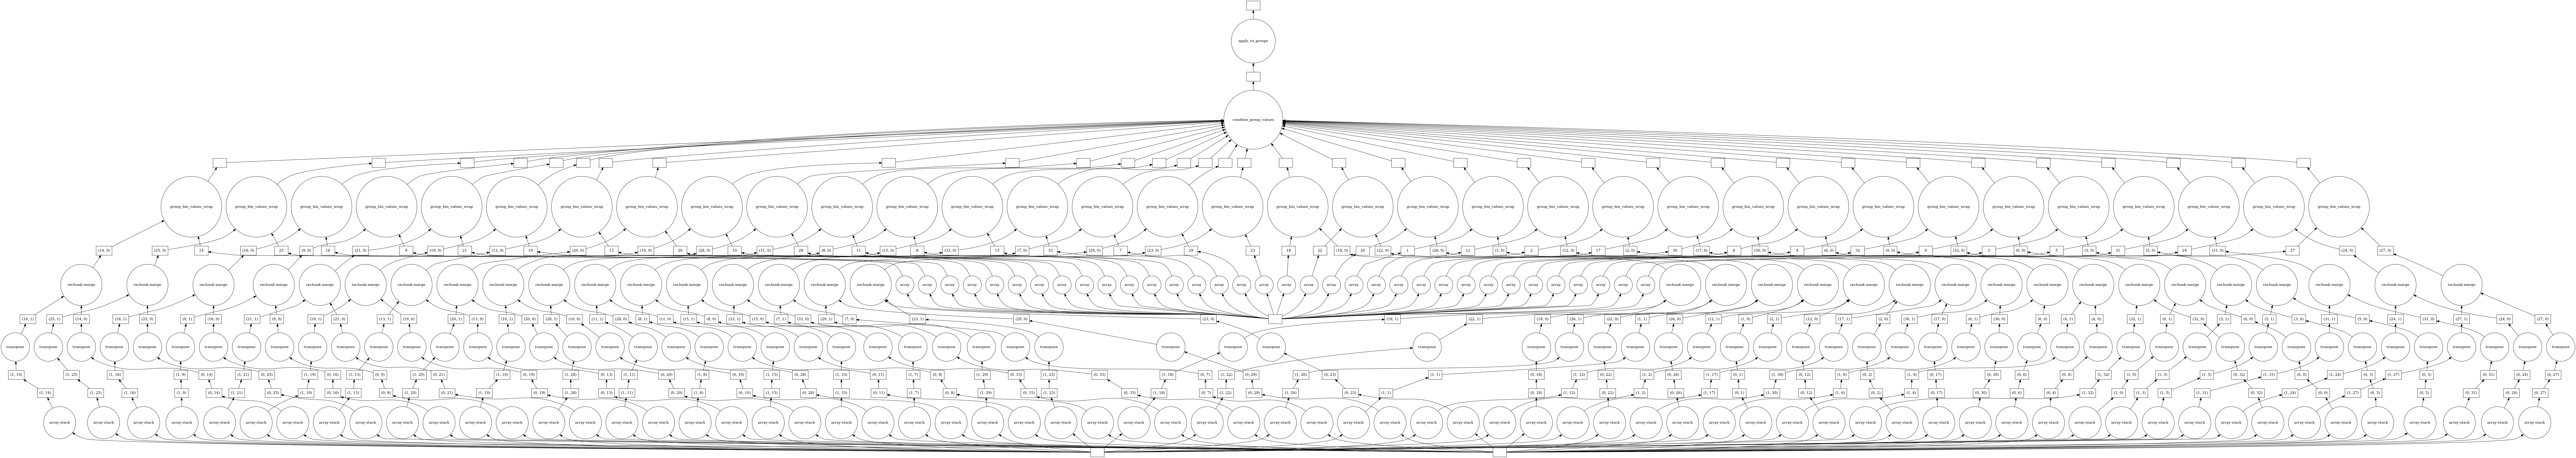

In [23]:
# Display Graph
function_result.visualize()

In [ ]:
# Compute the graph
%time bin_medians = function_result.compute()

---

## Gridplot of Bin Distribution 

In [20]:
from bokeh.layouts import gridplot 

In [ ]:
# Compute the grid from above without doing the combine step
%time value_groups = value_groups_.compute()

In [ ]:
# UV-grid bin count
len(value_groups), len(value_groups[0])

In [ ]:
ubin_number = 201
selbins = []
for i, r_ in enumerate(value_groups[ubin_number]):
    if len(r_) > 25000:
        print(f'({ubin_number}, {i}):\t {len(r_)}')
        selbins.append((ubin_number, i))

In [ ]:
def make_hist_plot(binname, bin_values, nbins):
    hist, edges = np.histogram(bin_values, density=True, bins=nbins)
    
    p = figure(title=f'{binname}', tools='')
    p.quad(bottom=0, top=hist, left=edges[:-1], right=edges[1:], fill_color='navy', alpha=0.7)
    return p

In [ ]:
# Plot a sample of bins and their amplitude distributions
show(gridplot(plots, ncols=5, plot_width=200, plot_height=200, toolbar_location=None))

---